In [1]:
import pandas as pd
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
import spacy
import string
from gensim.models.phrases import Phrases, Phraser
import pyLDAvis
import pyLDAvis.gensim
from gensim.utils import lemmatize
from pprint import pprint
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
cnn_text = pd.read_csv("../data/cnn_text.csv")

In [3]:
cnn_text.head()

,Abstract,Title,clean_text
0,Hypoglycemic events are common and potentially...,Automatic Detection of Hypoglycemic Events Fro...,hypoglycemic event common potentially dangerou...
1,Triaging of outpatient referrals to ophthalmol...,Triaging ophthalmology outpatient referrals wi...,triage outpatient referral ophthalmology servi...
2,Advances in deep learning (DL) have been trans...,Applied Deep Learning in Plastic Surgery: Clas...,advance deep learn dl transformative computer ...
3,A substantial portion of medical data is unstr...,Clinical Data Extraction and Normalization of ...,substantial portion medical datum unstructure ...
4,Data used for training of deep learning networ...,Structured report data can be used to develop ...,datum use training deep learning network usual...


In [4]:
stop_words = stopwords.words('english')
print(len(stop_words))
remove_words = ['overall', 'perform','attempts', 'model','use', 'calculating','performance','trainable',
                'data','result','representations','using','limited','used','feature','proposed','evaluate'
                ,'performance','algorithm','lr','ext','respective','respectively', 'accuracy', 'relatively'
                ,'small','challenge','validation','layer','better','three','detection','show','cnn','li', 
                'small','show','development','training','transfer','twos','cnns','pre','auroc','two','method',
                'parameters','segmentation','convolutional', 'neural', 'network', 'show','task','compare',
                'state','study', 'retrospective', 'datum','prediction','art','require', 'focus', 'base',
                'approach', 'paper', 'present', 'fall', 'due', 'recent', 'exponential', 'increase','analysis',
                'analysis','specificity','basis', 'function', 'kernel', 'area', 'curve', 'auc', 'may', 
                'useful','explore', 'two', 'different','test','models','system','deep', 'learning',
                'approach','require','may', 'useful','information', 'basis','obtain','methods','achieve',
                'level','al', 'research', 'grid', 'also','features', 'techniques', 'hard', 'parameter', 
                'sharing', 'cross', 'stitch', 'train', 'word', 'level', 'however','search', 'currently',
                'trained','article','analytic','datasets','fold', 'cross', 'propose','compared','based',
                'classification','results','dataset','multiple', 'time','architecture','end', 'sensitivity', 
                'specificity','proive','representation','input','technique','large','work','improve','layers',
                'set','learn','experiment','achieved','information','machine','offers', 'high','networks',
                'superior', 'classification', 'accuracy', 'for', 'automated', 'coding', 'support', 'aid', 'address',
               'available','https','important','role', 'application','good','rate','field','new','tool',
               'subject','value','map','quality','application','provide','one','mr', 'false','positive','tune','fine',
                'github','com','precision','recall','long','short','gold', 'standard','problem','demonstrate','apply',
                'well','truth','ground','similarity','coefficient','entity','event','cohort','molecular','goal','knowledge',
                'refer','conditional','name','natural','language','metho','processing','nlp','term', 'supplementary']

#identifies and removes duplicates and returns a lits of words
remove_words= list(set(remove_words))
stop_words.extend(remove_words)
print(len(remove_words))
print(len(stop_words))

179
197
376


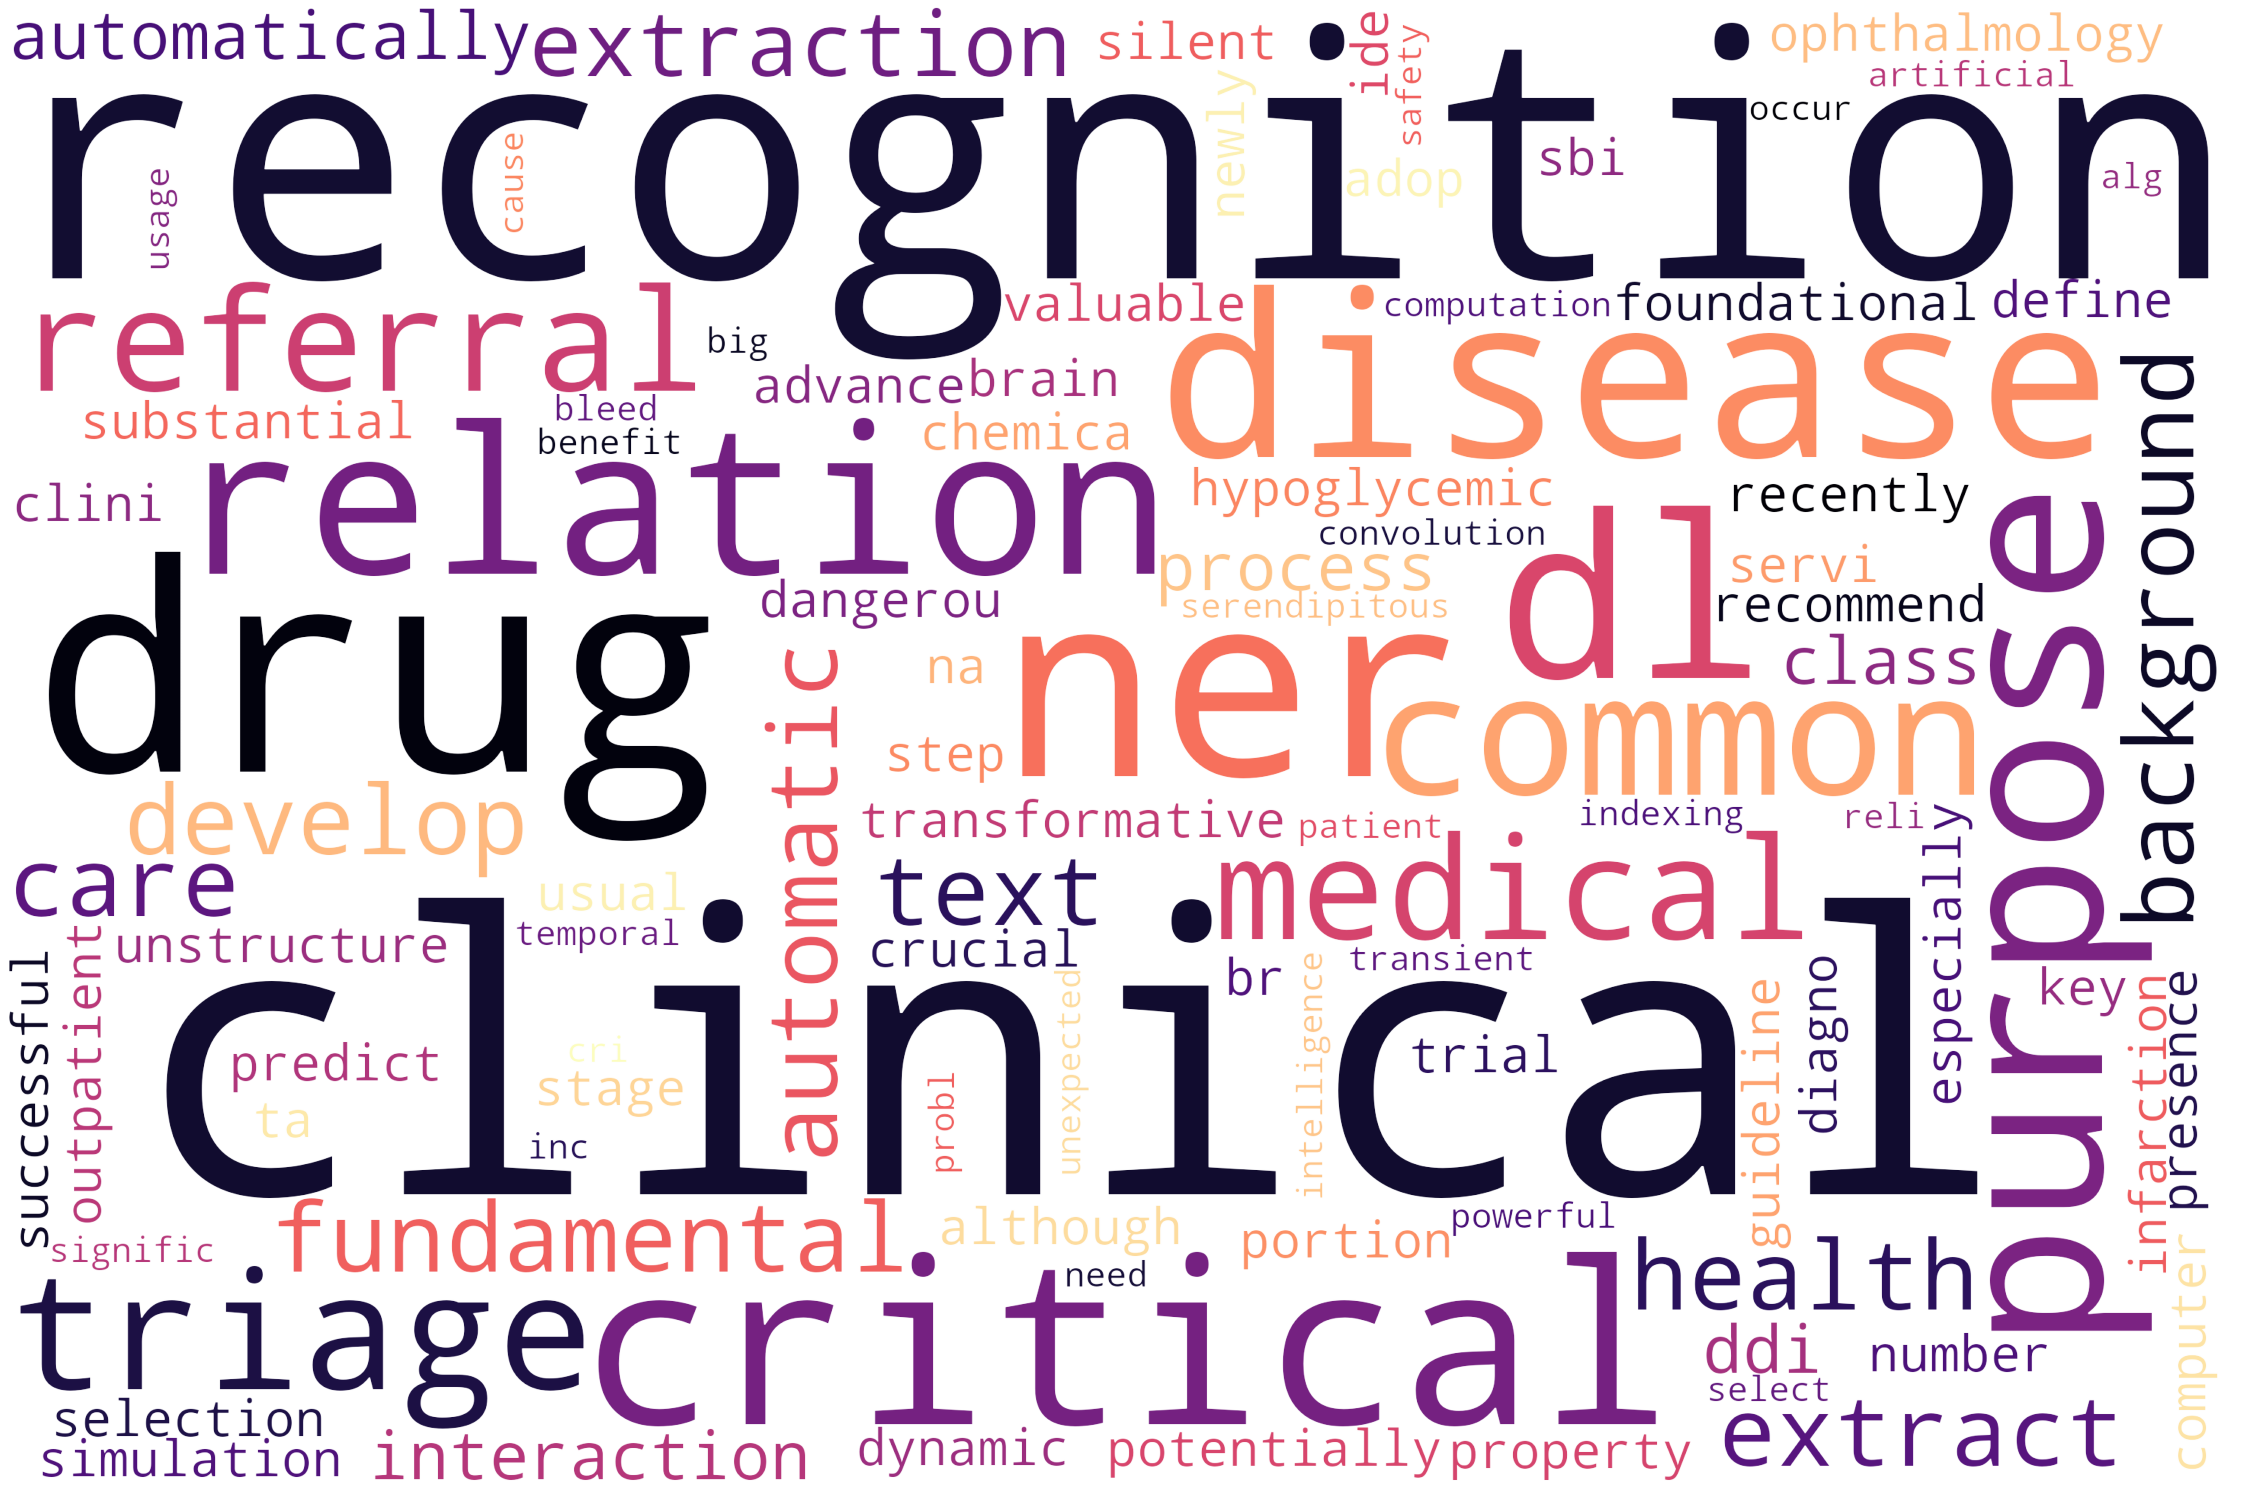

In [5]:
#Word cloud of 100 words in the entire clean text
wordcloud = WordCloud(width = 3000,
    height = 2000,background_color="rgba(255, 255, 255, 0)", mode="RGBA",colormap=plt.cm.magma,
                          stopwords=stop_words,
                          max_words=100,
                           
                          random_state=42,collocations=False
                         ).generate(str(cnn_text.clean_text))

#print(wordcloud)
plt.figure(figsize = (40, 30), edgecolor = 'k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
#plt.savefig("../data/word_cloud.png")
plt.show()



In [6]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
minus_stopwords = remove_stopwords(cnn_text.clean_text)

In [7]:
clean_text = [" ".join(x) for x in minus_stopwords]

In [8]:
def text_to_words(text):
    for sentence in text:
        yield(gensim.utils.simple_preprocess(str(sentence)))  # deacc=True removes punctuations

words_text = list(text_to_words(clean_text))

print(words_text[3])

['substantial', 'portion', 'medical', 'unstructure', 'extract', 'unstructured', 'text', 'barrier', 'advance', 'clinical', 'patient', 'care', 'addition', 'ongoing', 'predominately', 'english', 'whereas', 'inflected', 'non', 'latin', 'alphabet', 'slavic', 'cyrillic', 'alphabet', 'numerous', 'linguistic', 'develop', 'automatically', 'extract', 'biomarker', 'status', 'patient', 'breast', 'cancer', 'oncology', 'center', 'bulgaria', 'dual', 'embedding', 'english', 'bulgarian', 'encode', 'syntactic', 'polarity', 'embedding', 'subsequently', 'align', 'vector', 'space', 'embedding', 'recurrent', 'derive', 'biomarker', 'status', 'estrogen', 'receptor', 'progesterone', 'receptor', 'human', 'epidermal', 'growth', 'factor', 'receptor', 'resolve', 'ambiguity', 'highly', 'variable', 'medical', 'text', 'contain', 'latin', 'cyrillic', 'text', 'final', 'incorporate', 'english', 'bulgarian', 'syntax', 'polarity', 'embedding', 'score', 'estrogen', 'receptor', 'progesterone', 'receptor', 'human', 'epiderma

In [9]:
nlp = spacy.load('en', disable=['parser', 'ner'])
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
lemmatized_words = lemmatization(words_text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [11]:
#clean_text = [" ".join(x) for x in minus_stopwords]

                Bigram      Freq
0        clinical note  6.495961
1            free text  6.135063
2        clinical text  5.894427
3  attention mechanism  4.707107
4      computer vision  4.480556
5        random forest  4.480556
6        average score  4.445812


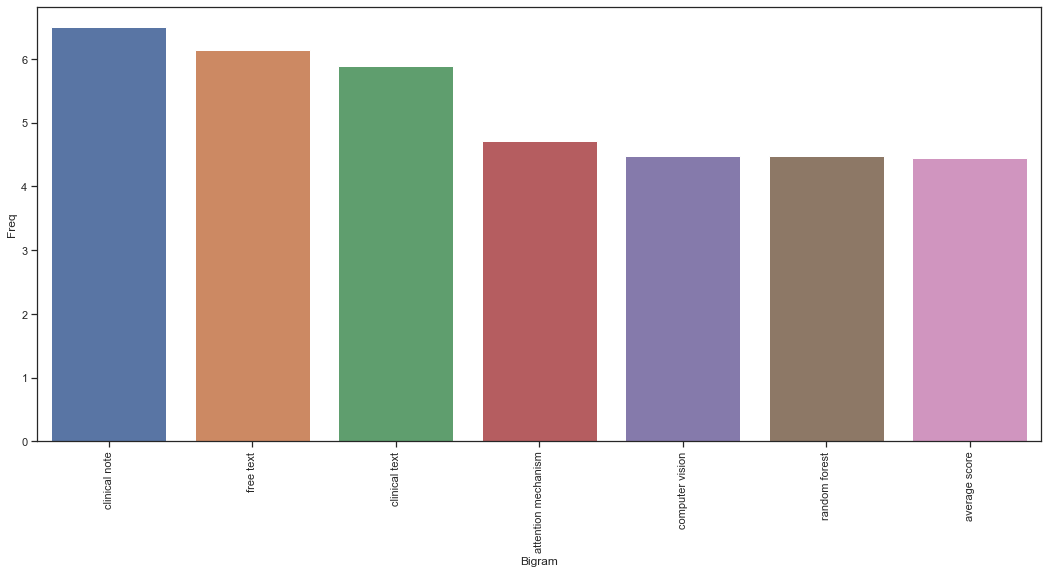

In [12]:
#Most frequently occuring bigrams in the data. plot both bar plot and word cloud of bigrams in the data 
def top_bi_grams(clean_text, n=None):
    clean_text = [" ".join(x) for x in lemmatized_words]
    vectorizer = TfidfVectorizer(ngram_range = (2,2), min_df = 5,stop_words=stop_words).fit(clean_text)
    bows = vectorizer.transform(clean_text)
    sumwords = bows.sum(axis=0) 
    words_freq = [(word, sumwords[0, idx]) for word, idx in     
                  vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

top_bigrams = top_bi_grams(clean_text, n=50)
top_bigrams_df = pd.DataFrame(top_bigrams)
top_bigrams_df.columns=["Bigram", "Freq"]
print(top_bigrams_df)

#Barplot of most freq Bi-grams
sns.set(rc={'figure.figsize':(18,8)}, style ='white' )
sns.set_style("ticks")

h=sns.barplot(x="Bigram", y="Freq", data=top_bigrams_df)
h.set_xticklabels(h.get_xticklabels(), rotation=90);

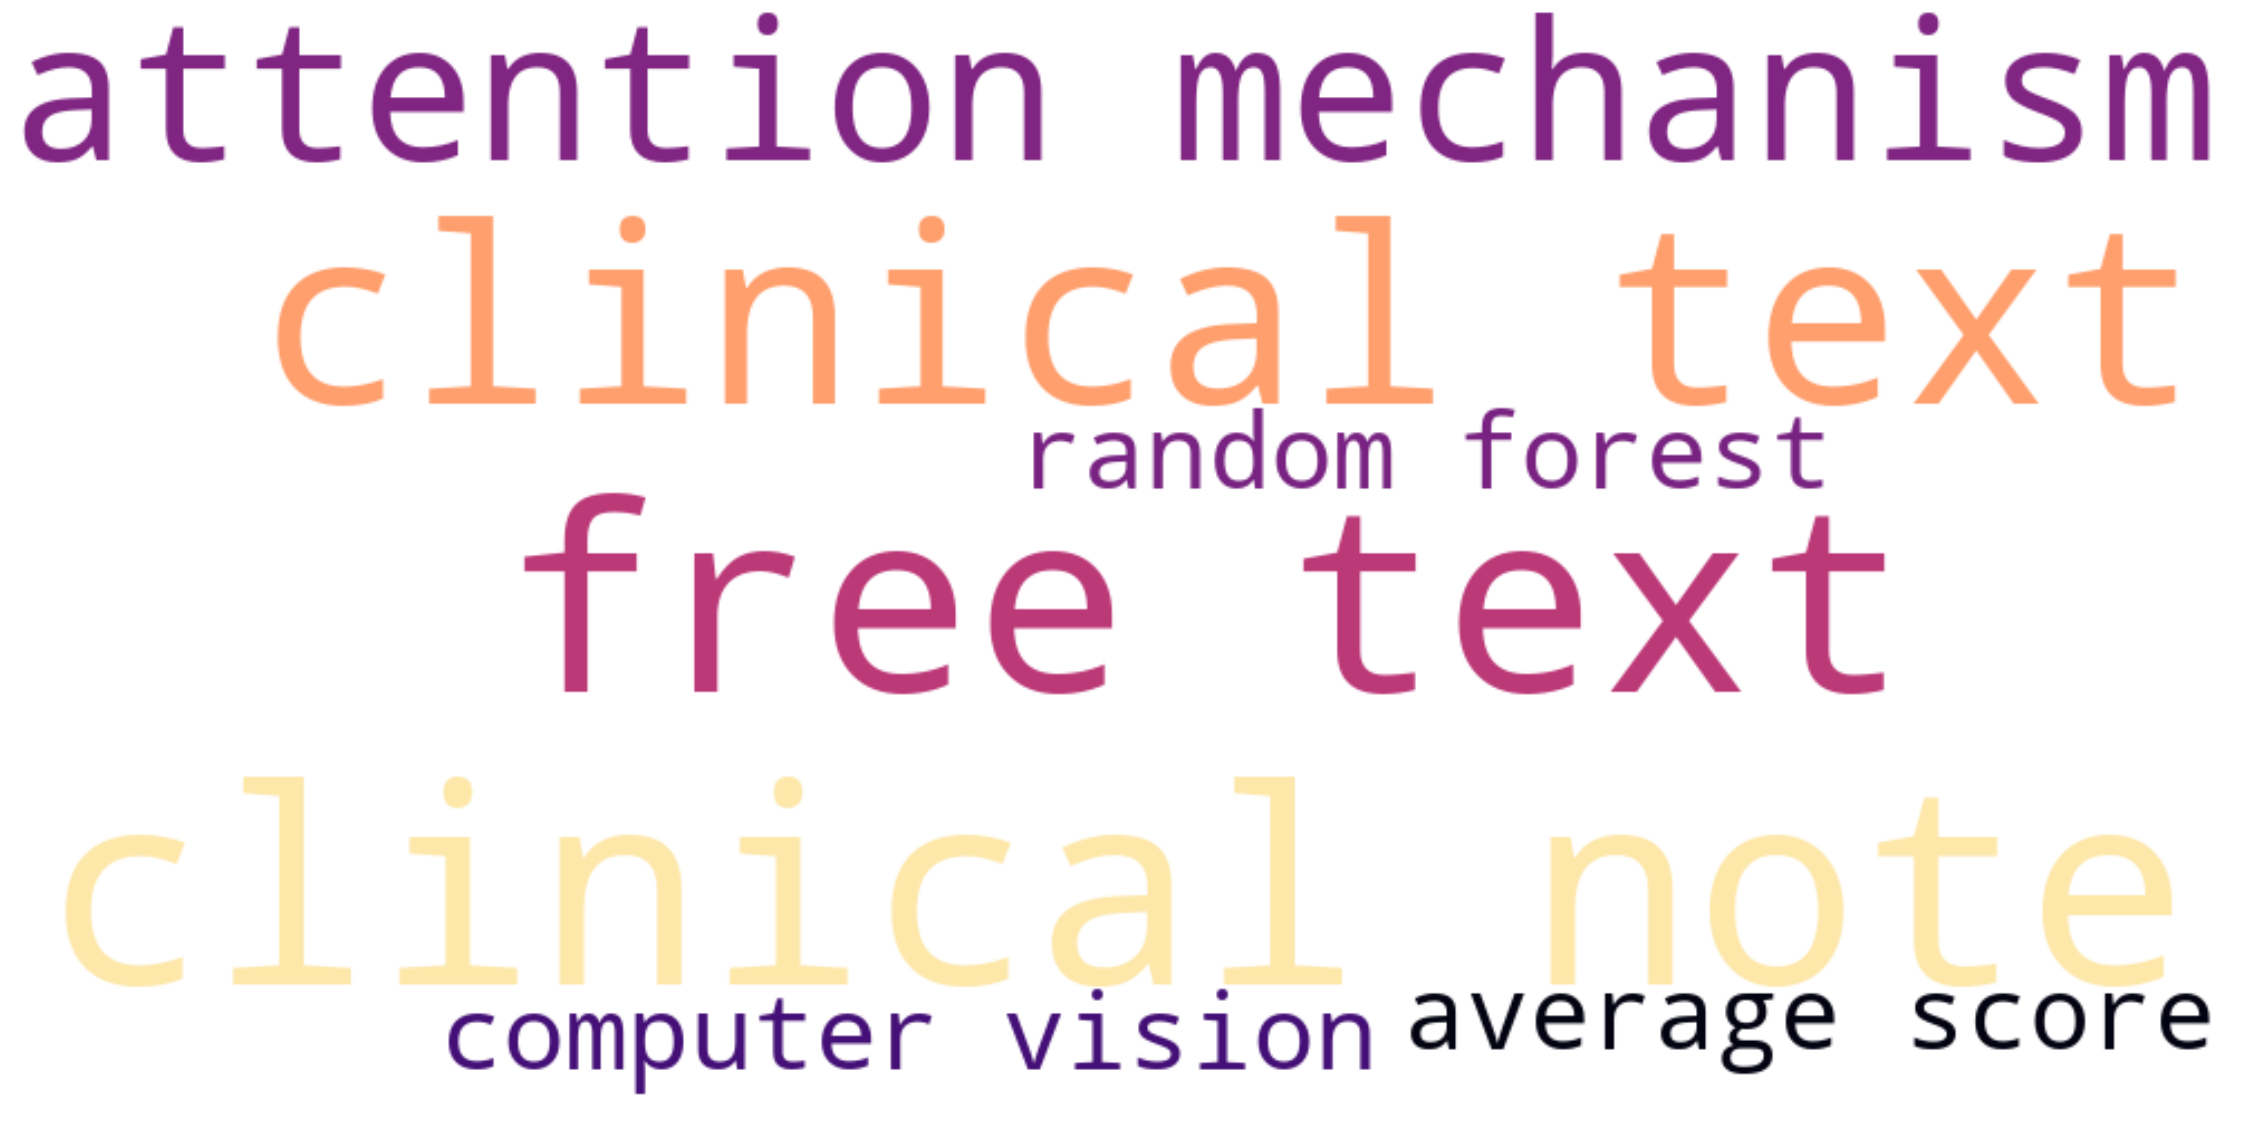

In [14]:
bigrams = {}
for w, x in top_bigrams_df.values:
    bigrams[w] = x
wordcloud = WordCloud(width = 1000,
    height = 500,background_color="white",colormap=plt.cm.magma,margin=5,
                      relative_scaling=1, collocations=False)
wordcloud.generate_from_frequencies(bigrams)
plt.figure(figsize = (40, 30),
    
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("../data/word_cloud_cnn_text.png", bbox_inches='tight')
plt.show()

In [15]:
bigram = Phrases(lemmatized_words, min_count=1, threshold=100)
trigram = Phrases(lemmatized_words, min_count=1, threshold=100)
bigrams_mod = Phraser(bigram)
trigrams_mod = Phraser(trigram)

In [16]:
def bigrams(texts):
    return [bigrams_mod[doc] for doc in texts]
words_bigrams = bigrams(lemmatized_words)

def trigrams(texts):
    return [trigrams_mod[doc] for doc in texts]
words_trigrams = trigrams(lemmatized_words)

In [17]:
nlp = spacy.load('en', disable=['parser', 'ner'])

In [18]:
# Create Dictionary
id2word = corpora.Dictionary(words_bigrams)


# Create Corpus
texts = words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:2])


[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 2), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 2), (23, 1), (24, 1), (25, 2), (26, 2), (27, 1), (28, 4), (29, 1), (30, 2), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1)], [(4, 1), (8, 1), (11, 2), (28, 1), (34, 1), (43, 1), (44, 1), (45, 3), (46, 2), (47, 1), (48, 1), (49, 1), (50, 1), (51, 6), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 2), (67, 2), (68, 1), (69, 1), (70, 1), (71, 2), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 4), (78, 1), (79, 1), (80, 1), (81, 2), (82, 1), (83, 1), (84, 1), (85, 4), (86, 2), (87, 1)]]


In [19]:
id2word[75]

'protect'

In [20]:
# Build LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=18, 
                     random_state=100,
                     update_every=1,
                     chunksize=1000,
                     passes=100,
                     alpha='auto',
                     per_word_topics=True)

In [21]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.045*"clinical" + 0.022*"report" + 0.022*"rule" + 0.022*"embed" + '
  '0.020*"text" + 0.015*"develop" + 0.015*"paradigm" + 0.013*"sbi" + '
  '0.013*"mapping" + 0.010*"mixture"'),
 (1,
  '0.019*"category" + 0.019*"triage" + 0.016*"patient" + 0.013*"referral" + '
  '0.013*"biomedical" + 0.013*"automatically" + 0.010*"accurately" + '
  '0.010*"radiology" + 0.010*"clinical" + 0.010*"determine"'),
 (2,
  '0.026*"relation" + 0.022*"medical" + 0.017*"temporal" + 0.017*"clinical" + '
  '0.013*"indexing" + 0.013*"serendipitous_drug" + 0.013*"recurrent" + '
  '0.013*"usage" + 0.013*"drug" + 0.011*"include"'),
 (3,
  '0.058*"report" + 0.037*"radiology" + 0.027*"text" + '
  '0.021*"sequence_labeling" + 0.021*"rule" + 0.016*"free" + '
  '0.011*"percentage" + 0.011*"global" + 0.011*"correctly" + 0.011*"find"'),
 (4,
  '0.021*"text" + 0.013*"loss" + 0.013*"camera" + 0.013*"track" + '
  '0.013*"object" + 0.013*"clinic" + 0.013*"clinical" + '
  '0.013*"history_complaint" + 0.013*"great" + 0.01

In [22]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.138094724391978

Coherence Score:  0.45220159131184406


In [23]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

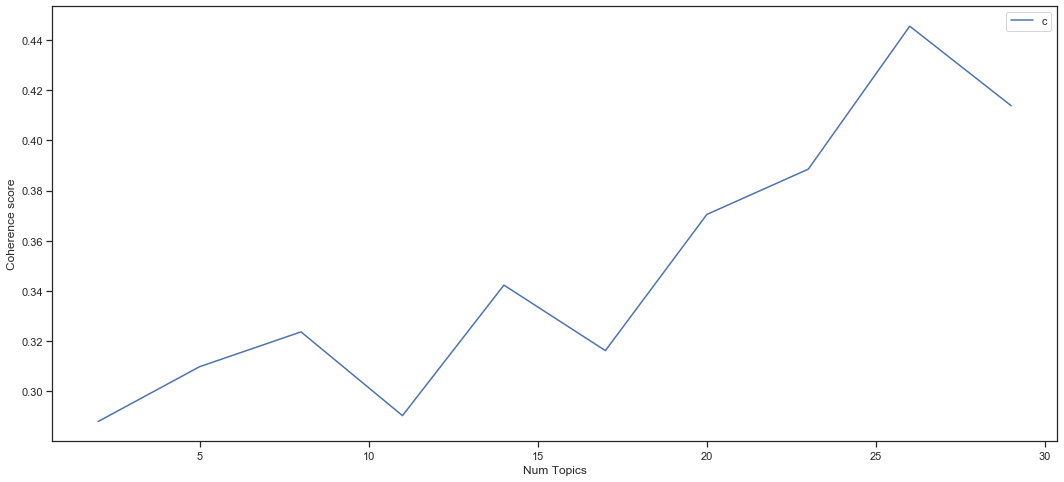

In [24]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=words_bigrams, start=2, limit=30, step=3)
# Show graph

limit=30; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [25]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17    -0.136716 -0.024547       1        1  11.194592
2     -0.102562  0.128049       2        1   9.697374
5      0.087117  0.148435       3        1   9.342159
9     -0.115401 -0.058021       4        1   9.059401
7     -0.046781 -0.025390       5        1   8.722951
0     -0.093998  0.076280       6        1   8.139717
16     0.085965  0.100432       7        1   6.807378
1      0.035991 -0.100352       8        1   5.907143
8      0.042397 -0.014596       9        1   5.669876
13    -0.094511 -0.022481      10        1   5.122674
10     0.057679 -0.098101      11        1   4.031473
4      0.044281 -0.068035      12        1   3.978780
11    -0.035454  0.023213      13        1   3.268165
3      0.092935  0.030618      14        1   2.841277
15     0.001524 -0.033399      15        1   2.294120
6      0.068489 -0.023758      16        1   2.066909
14     0.059884 -0.017135      17        1   1.846451
12     0.049160 -0.021212      18        1   0.009561, topic_info=    Category       Freq        Term      Total  loglift  logprob
219  Default  31.000000      report  31.000000  30.0000  30.0000
26   Default  33.000000        note  33.000000  29.0000  29.0000
144  Default  58.000000    clinical  58.000000  28.0000  28.0000
184  Default  41.000000        text  41.000000  27.0000  27.0000
258  Default  17.000000  extraction  17.000000  26.0000  26.0000
..       ...        ...         ...        ...      ...      ...
428  Topic18   0.000282     crystal   1.459745   0.7036  -7.2174
429  Topic18   0.000282    database   3.517673  -0.1760  -7.2174
430  Topic18   0.000282  descriptor   2.138438   0.3218  -7.2174
431  Topic18   0.000282     dynamic   3.074560  -0.0413  -7.2174
432  Topic18   0.000282      employ   6.244210  -0.7498  -7.2174

[1180 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
355       2  0.472601  ability
355      14  0.472601  ability
187       3  0.260801   absent
187       5  0.521603   absent
187      11  0.260801   absent
...     ...       ...      ...
232       3  0.662912    write
1223     13  0.762368      yet
42        6  0.274700    yield
42        8  0.549400    yield
42       13  0.274700    yield

[1796 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 3, 6, 10, 8, 1, 17, 2, 9, 14, 11, 5, 12, 4, 16, 7, 15, 13])

In [26]:
pyLDAvis.save_html(vis, '../data/lda_text.html')